# Aircraft Model - Classification Model (Crepe)
#### Binary Classifier 
Last Updated December 5, 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import pprint
random.seed(42)
import librosa
import scipy.signal
from scipy.signal import resample
import glob

In [2]:

from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
import seaborn as sns
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import MaxPooling3D, Flatten, Conv3D
from keras import backend as K
from keras.layers import LeakyReLU,PReLU
import keras
from keras.losses import *
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math



Using TensorFlow backend.
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\py

### Load and Inspect Data

In [3]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.

os.chdir("D:\\aircraft-audio\\local-data")
print(os.getcwd())

Boeing_slices_train_matrix = np.loadtxt('Boeing_slices_train_matrix.txt', delimiter=',')
Boeing_slices_test_matrix = np.loadtxt('Boeing_slices_test_matrix.txt', delimiter=',')
Embraer_slices_train_matrix = np.loadtxt('Embraer_slices_train_matrix.txt', delimiter=',')
Embraer_slices_test_matrix = np.loadtxt('Embraer_slices_test_matrix.txt', delimiter=',')
Bombardier_slices_train_matrix = np.loadtxt('Bombardier_slices_train_matrix.txt', delimiter=',')
Bombardier_slices_test_matrix = np.loadtxt('Bombardier_slices_test_matrix.txt', delimiter=',')
Airbus_slices_train_matrix = np.loadtxt('Airbus_slices_train_matrix.txt', delimiter=',')
Airbus_slices_test_matrix = np.loadtxt('Airbus_slices_test_matrix.txt', delimiter=',')

D:\aircraft-audio\local-data


[-4501. -4725. -3986. ... -1628. -1210. -1030.]


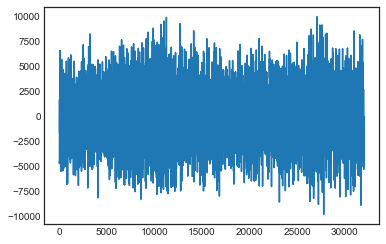

In [4]:
signal = Boeing_slices_train_matrix[40,:]
time = 32000
print(signal)
plt.plot(signal)
plt.show()

### Add Augmented Data

In [5]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [6]:
# Create Augmented matrices with volume reduction
Boeing_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Boeing_slices_train_matrix, -5)
Embraer_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Embraer_slices_train_matrix, -5)
Bombardier_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Bombardier_slices_train_matrix, -5)
Airbus_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Airbus_slices_train_matrix, -5)


In [7]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [8]:
# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.01)
Boeing_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Boeing_slices_train_matrix,0.01)
Bombardier_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Bombardier_slices_train_matrix,0.01)
Airbus_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Airbus_slices_train_matrix,0.01)

# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.09)
Boeing_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Boeing_slices_train_matrix,0.09)
Bombardier_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Bombardier_slices_train_matrix,0.09)
Airbus_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Airbus_slices_train_matrix,0.09)


### Add Labels

In [9]:
#Source Data Matrices

Boeing_slices_train_matrix = np.c_[ np.ones(len(Boeing_slices_train_matrix)),Boeing_slices_train_matrix] 
Boeing_slices_train_matrix[:, 0] =  0
print(Boeing_slices_train_matrix.shape)

Boeing_slices_test_matrix = np.c_[ np.ones(len(Boeing_slices_test_matrix)),Boeing_slices_test_matrix] 
Boeing_slices_test_matrix[:, 0] =  0
print(Boeing_slices_test_matrix.shape)

Embraer_slices_train_matrix = np.c_[ np.ones(len(Embraer_slices_train_matrix)),Embraer_slices_train_matrix] 
Embraer_slices_train_matrix[:, 0] = 1
print(Embraer_slices_train_matrix.shape)

Embraer_slices_test_matrix = np.c_[ np.ones(len(Embraer_slices_test_matrix)),Embraer_slices_test_matrix] 
Embraer_slices_test_matrix[:, 0] =  1
print(Embraer_slices_test_matrix.shape)

Bombardier_slices_train_matrix = np.c_[ np.ones(len(Bombardier_slices_train_matrix)),Bombardier_slices_train_matrix] 
Bombardier_slices_train_matrix[:, 0] = 0
print(Bombardier_slices_train_matrix.shape)

Bombardier_slices_test_matrix = np.c_[ np.ones(len(Bombardier_slices_test_matrix)),Bombardier_slices_test_matrix] 
Bombardier_slices_test_matrix[:, 0] =  0
print(Bombardier_slices_test_matrix.shape)

Airbus_slices_train_matrix = np.c_[ np.ones(len(Airbus_slices_train_matrix)),Airbus_slices_train_matrix] 
Airbus_slices_train_matrix[:, 0] = 0
print(Embraer_slices_train_matrix.shape)

Airbus_slices_test_matrix = np.c_[ np.ones(len(Airbus_slices_test_matrix)),Airbus_slices_test_matrix] 
Airbus_slices_test_matrix[:, 0] =  0
print(Airbus_slices_test_matrix.shape)

(98, 32001)
(46, 32001)
(28, 32001)
(15, 32001)
(10, 32001)
(24, 32001)
(28, 32001)
(12, 32001)


In [10]:
#Augmented Matrices

Boeing_augmented_train_matrix = np.c_[ np.ones(len(Boeing_augmented_train_matrix)),Boeing_augmented_train_matrix] 
Boeing_augmented_train_matrix[:, 0] = 0
Boeing_augmented_train_matrix = np.delete(Boeing_augmented_train_matrix, (0), axis=0)
print(Boeing_augmented_train_matrix.shape)

Embraer_augmented_train_matrix = np.c_[ np.ones(len(Embraer_augmented_train_matrix)),Embraer_augmented_train_matrix] 
Embraer_augmented_train_matrix[:, 0] = 1
Embraer_augmented_train_matrix = np.delete(Embraer_augmented_train_matrix, (0), axis=0)
print(Embraer_augmented_train_matrix.shape)

Bombardier_augmented_train_matrix = np.c_[ np.ones(len(Bombardier_augmented_train_matrix)),Bombardier_augmented_train_matrix] 
Bombardier_augmented_train_matrix[:, 0] = 0
Bombardier_augmented_train_matrix = np.delete(Bombardier_augmented_train_matrix, (0), axis=0)
print(Bombardier_augmented_train_matrix.shape)

Airbus_augmented_train_matrix = np.c_[ np.ones(len(Airbus_augmented_train_matrix)),Airbus_augmented_train_matrix] 
Airbus_augmented_train_matrix[:, 0] = 0
Airbus_augmented_train_matrix = np.delete(Airbus_augmented_train_matrix, (0), axis=0)
print(Airbus_augmented_train_matrix.shape)

#Augmented Matrices #2
Boeing_augmented_train_matrix2 = np.c_[ np.ones(len(Boeing_augmented_train_matrix2)),Boeing_augmented_train_matrix2] 
Boeing_augmented_train_matrix2[:, 0] = 0
Boeing_augmented_train_matrix2 = np.delete(Boeing_augmented_train_matrix2, (0), axis=0)
print(Boeing_augmented_train_matrix2.shape)

Embraer_augmented_train_matrix2 = np.c_[ np.ones(len(Embraer_augmented_train_matrix2)),Embraer_augmented_train_matrix2] 
Embraer_augmented_train_matrix2[:, 0] = 1
Embraer_augmented_train_matrix2 = np.delete(Embraer_augmented_train_matrix2, (0), axis=0)
print(Embraer_augmented_train_matrix2.shape)

Bombardier_augmented_train_matrix2 = np.c_[ np.ones(len(Bombardier_augmented_train_matrix2)),Bombardier_augmented_train_matrix2] 
Bombardier_augmented_train_matrix2[:, 0] = 0
Bombardier_augmented_train_matrix2 = np.delete(Bombardier_augmented_train_matrix2, (0), axis=0)
print(Bombardier_augmented_train_matrix2.shape)

Airbus_augmented_train_matrix2 = np.c_[ np.ones(len(Airbus_augmented_train_matrix2)),Airbus_augmented_train_matrix2] 
Airbus_augmented_train_matrix2[:, 0] = 0
Airbus_augmented_train_matrix2 = np.delete(Airbus_augmented_train_matrix2, (0), axis=0)
print(Airbus_augmented_train_matrix2.shape)


#Augmented Matrices #3

Boeing_augmented_train_matrix3 = np.c_[ np.ones(len(Boeing_augmented_train_matrix3)),Boeing_augmented_train_matrix3] 
Boeing_augmented_train_matrix3[:, 0] = 0
Boeing_augmented_train_matrix3 = np.delete(Boeing_augmented_train_matrix3, (0), axis=0)
print(Boeing_augmented_train_matrix3.shape)

Embraer_augmented_train_matrix3 = np.c_[ np.ones(len(Embraer_augmented_train_matrix3)),Embraer_augmented_train_matrix3] 
Embraer_augmented_train_matrix3[:, 0] = 1
Embraer_augmented_train_matrix3 = np.delete(Embraer_augmented_train_matrix3, (0), axis=0)
print(Embraer_augmented_train_matrix3.shape)

Bombardier_augmented_train_matrix3 = np.c_[ np.ones(len(Bombardier_augmented_train_matrix3)),Bombardier_augmented_train_matrix3] 
Bombardier_augmented_train_matrix3[:, 0] = 0
Bombardier_augmented_train_matrix3 = np.delete(Bombardier_augmented_train_matrix3, (0), axis=0)
print(Bombardier_augmented_train_matrix3.shape)

Airbus_augmented_train_matrix3 = np.c_[ np.ones(len(Airbus_augmented_train_matrix3)),Airbus_augmented_train_matrix3] 
Airbus_augmented_train_matrix3[:, 0] = 0
Airbus_augmented_train_matrix3 = np.delete(Airbus_augmented_train_matrix3, (0), axis=0)
print(Airbus_augmented_train_matrix3.shape)

(98, 32001)
(28, 32001)
(10, 32001)
(69, 32001)
(98, 32001)
(28, 32001)
(10, 32001)
(69, 32001)
(98, 32001)
(28, 32001)
(10, 32001)
(69, 32001)


### Split and Shuffle Data

In [11]:
all_train_data = []

In [12]:
all_train_data = np.append(Boeing_slices_train_matrix, Embraer_slices_train_matrix, axis=0)
all_train_data = np.append(all_train_data, Bombardier_slices_train_matrix, axis=0)
all_train_data = np.append(all_train_data, Airbus_slices_train_matrix, axis=0)
 
# Add augmented data just to training matrix
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix3, axis=0)

all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix3, axis=0)

all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix3, axis=0)

all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix3, axis=0)
print(all_train_data.shape)


(820, 32001)


In [13]:
all_test_data = []

In [14]:
all_test_data = np.append(Boeing_slices_test_matrix, Embraer_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data, Bombardier_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data , Airbus_slices_test_matrix,axis=0)
print(all_test_data.shape)

np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

y_train = np.asarray(all_train_data[:,0])
X_train = np.asarray(all_train_data[:,1:32001])

y_test = np.asarray(all_test_data[:,0])
X_test = np.asarray(all_test_data[:,1:32001])

(97, 32001)


In [15]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(820,)
(820, 32000)
(97,)
(97, 32000)


In [16]:
trainsize = len(y_train)
print(trainsize)
testsize = len(y_test)
print(testsize)

820
97


In [17]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [18]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_test.any(axis=1))[0]
print(X_train_nulls.shape)
X_test_nulls.shape

(0,)


(0,)

### Featurizing

In [19]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [20]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [21]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [22]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print('row_count: ' + str(row_count))

    for row in range(0,row_count):
        freq = fundamental_freq_gen(data[row,:])
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print('crepe_input.shape:' + str(crepe_input.shape))

    crepe_input= crepe_input.reshape(row_count, crepe_input.shape[2])
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print('normalized_crepe_input.shape' + str(normalized_crepe_input.shape))
    return normalized_crepe_input

In [23]:
# Generate train and test features
crepe_train_input = _generate_features(X_train)
crepe_test_input = _generate_features(X_test)

row_count: 820







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
crepe_input.shape:(820, 1, 11)
normalized_crepe_input.shape(820, 11)
row_count: 97
crepe_input.shape:(97, 1, 11)
normalized_crepe_input.shape(97, 11)


In [24]:
print('input shapes')
print(crepe_train_input.shape)
print(crepe_test_input.shape)

input shapes
(820, 11)
(97, 11)


### Model Building
Because we are just using values from CREPE, let's stick with simple machine learning

In [25]:
# Scale data [-1, 1]
X_train = StandardScaler().fit_transform(crepe_train_input)
X_test = StandardScaler().fit_transform(crepe_test_input)
y_train = y_train
y_test = y_test

In [26]:
# Set up parameter grid search
Cs = [0.01, 0.1, 1, 2, 5]
kernels = ['linear', 'rbf']
degrees = [1, 2, 3]
parameters = {'C': Cs, 'degrees': degrees}
parameters = {'kernel':kernels, 'C':Cs, 'degree': degrees}

svc = svm.SVC(gamma='auto', class_weight='balanced')
grid = GridSearchCV(svc, param_grid=parameters, cv=10, verbose=True)

In [27]:
# Fit the grid
grid.fit(X_train, y_train)
clf = grid.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    8.9s finished


In [28]:
# Fit the model to the data
clf.fit(X_train, y_train)

SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Results

In [29]:
from sklearn.metrics import confusion_matrix
print('accuracy: ' + str(clf.score(X_test, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_test, clf.predict(X_test)))

accuracy: 0.5154639175257731
Confusion matrix:
[[39 43]
 [ 4 11]]


#### Confusion Matrix

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if j > 0:
                if i > 0:
                    j_pos = j
                    i_pos = i-0.25
                else:
                    j_pos = j
                    i_pos = i+0.25
            else:
                if i > 0:
                    j_pos = j
                    i_pos = i-0.25
                else:
                    j_pos = j
                    i_pos = i+0.25
            ax.text(j_pos, i_pos, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=16)
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[39 43]
 [ 4 11]]
Normalized confusion matrix
[[0.48 0.52]
 [0.27 0.73]]


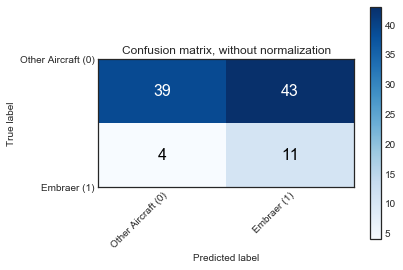

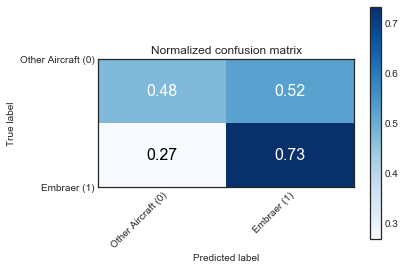

In [32]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, clf.predict(X_test), classes=['Other Aircraft (0)','Embraer (1)'],
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, clf.predict(X_test), classes=['Other Aircraft (0)','Embraer (1)'], normalize=True,
                                          title='Normalized confusion matrix')

# The End